In [11]:
import numpy as np
import pandas as pd
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

In [12]:
# metric functions
# MAE
def MAE(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

# RMSE
def RMSE(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred) ** 2))

In [13]:
# get the data
Addr_Inp = '/data/workspace_files/features_draft1.csv'

df_features = pd.read_csv(Addr_Inp)
df_features['Date'] = pd.to_datetime(df_features.Date.values)
df_features = df_features.iloc[:, 2:].set_index('Date')
print('Data loaded.')

Data loaded.


In [14]:
# build target data and look-back data
N_target = 7
Y_total = np.zeros((df_features.shape[0], N_target), dtype=np.float)
for i in range(N_target):
    Y_total[:-(i + 1), i] = df_features['Weighted Volume Price'].values[(i + 1):] / df_features[
        'Weighted Volume Price'].values[:-(i + 1)] - 1
print('Target data generated.')

N_lookback = 48
X_lookback = np.zeros((df_features.shape[0], N_lookback), dtype=np.float)
X_lookback[:, 0] = df_features['Weighted Volume Price'].values
for i in range(1, N_lookback):
    X_lookback[i:, i] = df_features['Weighted Volume Price'].values[:-i]
print('Lookback data generated.')

Target data generated.
Lookback data generated.


In [15]:
# truncate each dataset so that every value is meaningful
pos_beg = 199
df_features = df_features.iloc[pos_beg:-N_target, :]
df_features = df_features.iloc[:, 1:]
# normalize df_features so that training will be more stable
df_features.iloc[:, :] = (df_features.values - np.mean(df_features.values, axis=0)) / np.std(df_features.values, axis=0)
Y_total = Y_total[pos_beg:-N_target, :]
X_lookback = X_lookback[pos_beg:-N_target, :]
price_current = X_lookback[:, 0]
Y_total = pd.DataFrame(Y_total, index=df_features.index.values)
X_lookback = pd.DataFrame(X_lookback, index=df_features.index.values)

# normalize X_lookback
X_lookback_norm = (X_lookback.values - np.mean(X_lookback.values, axis=0)) / np.std(
    X_lookback.values, axis=0)
X_lookback_norm = pd.DataFrame(X_lookback_norm, index=df_features.index.values)
df_features_norm = (df_features.values - np.mean(df_features.values, axis=0)) / np.std(
    df_features.values, axis=0)
df_features_norm = pd.DataFrame(df_features_norm, index=df_features.index.values)

# divide these datasets into train, validation, and test
breakpoint_train_beg = pd.to_datetime('2014-07-23 00:00:00')
breakpoint_train_valid = pd.to_datetime('2019-02-01 00:00:00')
breakpoint_valid_test = pd.to_datetime('2019-08-01 00:00:00')
breakpoint_test_end = pd.to_datetime('2020-07-01 00:00:00')

price_current_train = price_current[(breakpoint_train_beg <= Y_total.index.values) &
                         (Y_total.index.values < breakpoint_train_valid)]
price_current_valid = price_current[(breakpoint_train_valid <= Y_total.index.values) &
                         (Y_total.index.values < breakpoint_valid_test)]
price_current_test = price_current[(breakpoint_valid_test <= Y_total.index.values) &
                        (Y_total.index.values < breakpoint_test_end)]

Y_train = Y_total.values[(breakpoint_train_beg <= Y_total.index.values) &
                         (Y_total.index.values < breakpoint_train_valid), :]
Y_valid = Y_total.values[(breakpoint_train_valid <= Y_total.index.values) &
                         (Y_total.index.values < breakpoint_valid_test), :]
Y_test = Y_total.values[(breakpoint_valid_test <= Y_total.index.values) &
                        (Y_total.index.values < breakpoint_test_end), :]

X_lookback_train_norm = X_lookback_norm.values[(breakpoint_train_beg <= Y_total.index.values) &
                                     (Y_total.index.values < breakpoint_train_valid), :]
X_lookback_valid_norm = X_lookback_norm.values[(breakpoint_train_valid <= X_lookback.index.values) &
                                     (X_lookback.index.values < breakpoint_valid_test), :]
X_lookback_test_norm = X_lookback_norm.values[(breakpoint_valid_test <= Y_total.index.values) &
                                    (Y_total.index.values < breakpoint_test_end), :]

X_features_train_norm = df_features_norm.values[(breakpoint_train_beg <= Y_total.index.values) &
                                      (Y_total.index.values < breakpoint_train_valid), :]
X_features_valid_norm = df_features_norm.values[(breakpoint_train_valid <= df_features.index.values) &
                                     (df_features.index.values < breakpoint_valid_test), :]
X_features_test_norm = df_features_norm.values[(breakpoint_valid_test <= Y_total.index.values) &
                                     (Y_total.index.values < breakpoint_test_end), :]

X_lookback_train = X_lookback.values[(breakpoint_train_beg <= Y_total.index.values) &
                                     (Y_total.index.values < breakpoint_train_valid), :]
X_lookback_valid = X_lookback.values[(breakpoint_train_valid <= X_lookback.index.values) &
                                     (X_lookback.index.values < breakpoint_valid_test), :]
X_lookback_test = X_lookback.values[(breakpoint_valid_test <= Y_total.index.values) &
                                    (Y_total.index.values < breakpoint_test_end), :]

In [16]:
# 1. build 2 simple benchmark predictions, and calculate MAE for the following on validation set
# a: Average
benchmark_valid_mean = np.mean(X_lookback_valid, axis=1)[:, np.newaxis]
MAE_benchmark_valid_mean = MAE((Y_valid + 1) * price_current_valid[:, np.newaxis], benchmark_valid_mean)
print('MAE for the average benchmark:', MAE_benchmark_valid_mean)

# b: Last value and using broadcasting to compare against the matrix of true values
benchmark_valid_last = X_lookback_valid[:, :1]
MAE_benchmark_valid_last = MAE((Y_valid + 1) * price_current_valid[:, np.newaxis], benchmark_valid_last)
print('MAE for the last benchmark:', MAE_benchmark_valid_last)

MAE for the average benchmark: 187.1302131647172
MAE for the last benchmark: 73.18754885432769


Training starts.
Model without Total Volume finished. MAE: 88.53990935243043
Model without MACD finished. MAE: 86.59467731348747
Model without 1 hour return finished. MAE: 90.7387470150584
Model without 2 hour return finished. MAE: 89.18765231450367
Model without 3 hour return finished. MAE: 91.40968079161948
Model without 4 hour return finished. MAE: 90.45501141584936
Model without 5 hour return finished. MAE: 90.62561380912227
Model without 6 hour return finished. MAE: 90.53019476043413
Model without 7 hour return finished. MAE: 88.25861424960311
Model without 50 hour moving average finished. MAE: 92.34846628143013
Model without 200 hour moving average finished. MAE: 86.11682856069996
Model without 20 hour volatility finished. MAE: 89.11594284050294
Model without 100 hour volatility finished. MAE: 88.2843305643523
Model without 200 hour volatility finished. MAE: 91.54491422135303
Model without RSI finished. MAE: 88.97444144835367
Model without bollinger_up_7hr finished. MAE: 89.47592

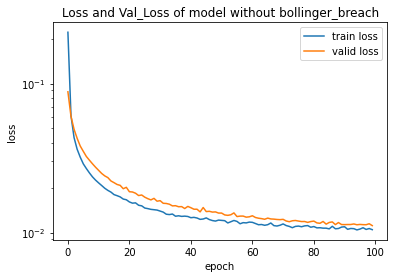

In [17]:
# 2. build and train a simple neural network by flattening the data and use 2 layers
    # calculate the train and validation loss for each epoch

# calculate the MAE for each NN with all features but one
    # and select features that are most important (having highest MAE without these features)
Arr_feature_name = df_features.columns.values

N_features = len(Arr_feature_name)
Vec_MAE_missing = np.zeros(N_features, dtype=np.float)

n_epochs, batch_size = 100, 512
LR = 0.0003

print('Training starts.')
for i in range(N_features):

    # construct X_train, X_valid based on this missing feature
    if i == 0:
        X_features_train_missing = X_features_train_norm[:, 1:]
        X_features_valid_missing = X_features_valid_norm[:, 1:]
    elif i == N_features - 1:
        X_features_train_missing = X_features_train_norm[:, :-1]
        X_features_valid_missing = X_features_valid_norm[:, :-1]
    else:
        X_features_train_missing = np.column_stack([X_features_train_norm[:, :i], X_features_train_norm[:, (i + 1):]])
        X_features_valid_missing = np.column_stack([X_features_valid_norm[:, :i], X_features_valid_norm[:, (i + 1):]])

    X_train_missing = np.column_stack([X_lookback_train_norm, X_features_train_missing])
    X_valid_missing = np.column_stack([X_lookback_valid_norm, X_features_valid_missing]) 

    # train the neural network and output loss and validation loss
    mod_NN_Simple = tf.keras.Sequential([tf.keras.layers.Dense(64, input_shape=[X_train_missing.shape[1]],
                                                               activation='relu',
                                                               kernel_initializer='he_uniform'),
                                         tf.keras.layers.Dense(256, activation='relu', kernel_initializer='he_uniform'),
                                         tf.keras.layers.Dense(N_target)])
    mod_NN_Simple.compile(loss=tf.keras.losses.MeanAbsoluteError(),
                          optimizer=tf.keras.optimizers.Adam(learning_rate=LR))

    fit_history = mod_NN_Simple.fit(X_train_missing, Y_train, epochs=n_epochs,
                                    batch_size=batch_size, verbose=0,
                                    validation_data=(X_valid_missing, Y_valid))

    # record the validation loss after training
    Vec_MAE_missing[i] = MAE(((Y_valid + 1) * price_current_valid[:, np.newaxis]), 
                             (mod_NN_Simple.predict(X_valid_missing) + 1) * price_current_valid[:, np.newaxis])
    print('Model without', Arr_feature_name[i], 'finished. MAE:', Vec_MAE_missing[i])

    # plot the train and validation loss for each epoch
    plt.plot(fit_history.history['loss'], label='train loss')
    plt.plot(fit_history.history['val_loss'], label='valid loss')
    plt.title('Loss and Val_Loss of model without ' + Arr_feature_name[i])
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.yscale('log')
    plt.legend()
    plt.show()

In [18]:
# select features which model without it has the highest MAE
index_feat_selected = np.argsort(Vec_MAE_missing)[::-1][:10]
print('Selected features:', Arr_feature_name[index_feat_selected])

X_features_train_norm = X_features_train_norm[:, index_feat_selected]
X_features_valid_norm = X_features_valid_norm[:, index_feat_selected]
X_features_test_norm = X_features_test_norm[:, index_feat_selected]
X_train = np.column_stack([X_lookback_train_norm, X_features_train_norm])
X_valid = np.column_stack([X_lookback_valid_norm, X_features_valid_norm])
X_test = np.column_stack([X_lookback_test_norm, X_features_test_norm])

Selected features: ['50 hour moving average' '200 hour volatility' '3 hour return'
 'bollinger_down_7hr' 'bollinger_breach' '1 hour return' '5 hour return'
 '6 hour return' '4 hour return' 'bollinger_up_7hr']


Epoch 1/100
78/78 [==============================] - 1s 5ms/step - loss: 0.1868 - val_loss: 0.0512
Epoch 2/100
78/78 [==============================] - 0s 4ms/step - loss: 0.0388 - val_loss: 0.0353
Epoch 3/100
78/78 [==============================] - 0s 4ms/step - loss: 0.0281 - val_loss: 0.0292
Epoch 4/100
78/78 [==============================] - 0s 6ms/step - loss: 0.0239 - val_loss: 0.0262
Epoch 5/100
78/78 [==============================] - 0s 6ms/step - loss: 0.0222 - val_loss: 0.0237
Epoch 6/100
78/78 [==============================] - 0s 6ms/step - loss: 0.0202 - val_loss: 0.0222
Epoch 7/100
78/78 [==============================] - 0s 6ms/step - loss: 0.0192 - val_loss: 0.0210
Epoch 8/100
78/78 [==============================] - 0s 6ms/step - loss: 0.0181 - val_loss: 0.0200
Epoch 9/100
78/78 [==============================] - 0s 6ms/step - loss: 0.0174 - val_loss: 0.0192
Epoch 10/100
78/78 [==============================] - 0s 6ms/step - loss: 0.0166 - val_loss: 0.0187
Epoch 11/

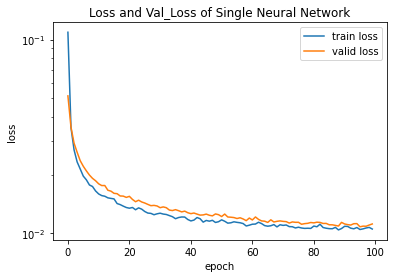

In [19]:
# use this selected data to train the neural network
mod_NN_Simple = tf.keras.Sequential([tf.keras.layers.Dense(64, input_shape=[X_train.shape[1]],
                                                           activation='relu',
                                                           kernel_initializer='he_uniform'),
                                     tf.keras.layers.Dense(256, activation='relu', kernel_initializer='he_uniform'),
                                     tf.keras.layers.Dense(N_target)])
mod_NN_Simple.compile(loss=tf.keras.losses.MeanAbsoluteError(),
                      optimizer=tf.keras.optimizers.Adam(learning_rate=LR))

fit_history = mod_NN_Simple.fit(X_train, Y_train, epochs=n_epochs,
                                batch_size=batch_size, verbose=1,
                                validation_data=(X_valid, Y_valid))

print('MAE for simple NN:', MAE(((Y_valid + 1) * price_current_valid[:, np.newaxis]),
                                (mod_NN_Simple.predict(X_valid) + 1) * price_current_valid[:, np.newaxis]))

# plot the train and validation loss for each epoch
plt.plot(fit_history.history['loss'], label='train loss')
plt.plot(fit_history.history['val_loss'], label='valid loss')
plt.title('Loss and Val_Loss of Single Neural Network')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.yscale('log')
plt.legend()
plt.show()